# Stock Prediction - Internship Task # 2

In this project, we use historical Apple stock data with technical indicators (RSI, MACD, Bollinger Bands) to build an LSTM model that predicts future closing prices.
We go through steps of downloading, feature engineering, preprocessing, training, and evaluating the model.

In [21]:
#Verified Python environment to ensure code runs in the correct interpreter.(Setting up environment)
import sys
print(sys.executable)

c:\Users\Dell\AppData\Local\Programs\Python\Python313\python.exe


### Import libraries
Loads data science libraries (Pandas, NumPy).

matplotlib for plotting.

yfinance for downloading stock data.

sklearn tools for scaling and model evaluation.

tensorflow.keras for building the LSTM neural network.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Download Data

Downloads Apple (AAPL) stock price data between 2015–2023.

Includes daily Open, High, Low, Close, Volume.

In [44]:
ticker = "AAPL" 
data = yf.download(ticker, start="2015-01-01", end="2023-12-31")

C:\Users\Dell\AppData\Local\Temp\ipykernel_8168\1487393558.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


### Feauture Engineering (Adding technical indicators)

RSI → relative strength index (momentum).

MACD → moving average convergence divergence (trend).

Bollinger Bands → price volatility bands.

Drops rows with missing values (from rolling calculations).

In [45]:
# RSI (14-day)
delta = data["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
data["RSI"] = 100 - (100 / (1 + rs))

# MACD (12 EMA - 26 EMA)
ema12 = data["Close"].ewm(span=12, adjust=False).mean()
ema26 = data["Close"].ewm(span=26, adjust=False).mean()
data["MACD"] = ema12 - ema26

# Bollinger Bands (20 MA ± 2 STD)
ma20 = data["Close"].rolling(window=20).mean()
std20 = data["Close"].rolling(window=20).std()
data["Bollinger_Upper"] = ma20 + (std20 * 2)
data["Bollinger_Lower"] = ma20 - (std20 * 2)

# Drop NaN rows created by indicators
data.dropna(inplace=True)


### Data Preparation 

Selects relevant features.

Normalizes them to [0, 1] range with MinMaxScaler.

Splits into 80% training / 20% testing sets.

### Creating sequences for LSTM

Creates 60-day rolling windows as input (X).

Each sequence predicts the next day’s closing price (y).

In [54]:
features = data[["Open", "High", "Low", "Close", "Volume",
                 "RSI", "MACD", "Bollinger_Upper", "Bollinger_Lower"]]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
def create_sequences(dataset, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(dataset)):
        X.append(dataset[i-seq_length:i, :])
        y.append(dataset[i, 3])  # predict "Close"
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

### Build and Compile LSTM Model

2 LSTM layers (100 units each).

Dropout to reduce overfitting.

Dense layers for regression output.

Optimizer: Adam, loss: MSE.

### Train the Model

EarlyStopping prevents overfitting by halting when validation loss stops improving.

Trains for up to 50 epochs with batch size 32.

In [55]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mean_squared_error")

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)





Epoch 1/50


c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.9663e-04 - val_loss: 0.0021
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 7.8377e-04 - val_loss: 0.0015
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.4210e-04 - val_loss: 0.0012
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.4608e-04 - val_loss: 0.0048
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.8107e-04 - val_loss: 0.0035
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 5.3533e-04 - val_loss: 0.0049
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.3003e-04 - val_loss: 0.0048
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 5.7090e-04 - val_loss: 0.0011
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 4.6470e-04 - val_loss: 0.0015
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 6.0407e-04 - val_loss: 0.0023
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━

### Make Predictions and Evaluate

Predicts closing prices on test data.

Rescales back to USD prices.

Evaluates performance using:

    MSE (Mean Squared Error)

    RMSE (Root MSE, average error in $)

    R² (explained variance)

    MAPE (average % error)

### Final Result

MSE = 42.40

RMSE = 6.51 USD

R² = 0.8848

MAPE = 3.46%

In [56]:
y_pred = model.predict(X_test)

# Rescale back to original USD prices
scaler_close = MinMaxScaler()
scaler_close.fit(features[["Close"]].values)
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_close.inverse_transform(y_pred)

# Evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print("\n Final Model Evaluation Metrics:")
print(f"  MSE  : {mse:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  R²   : {r2:.4f}")
print(f"  MAPE : {mape:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

 Final Model Evaluation Metrics:
  MSE  : 66.0149
  RMSE : 8.1250
  R²   : 0.8207
  MAPE : 3.88%


### Plotting Graph

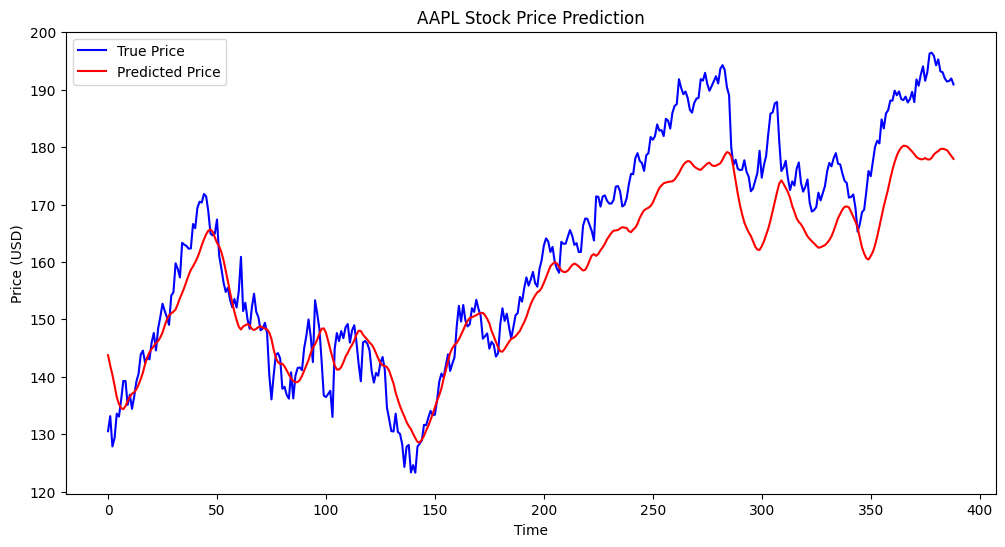

In [57]:

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="True Price", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Price", color="red")
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


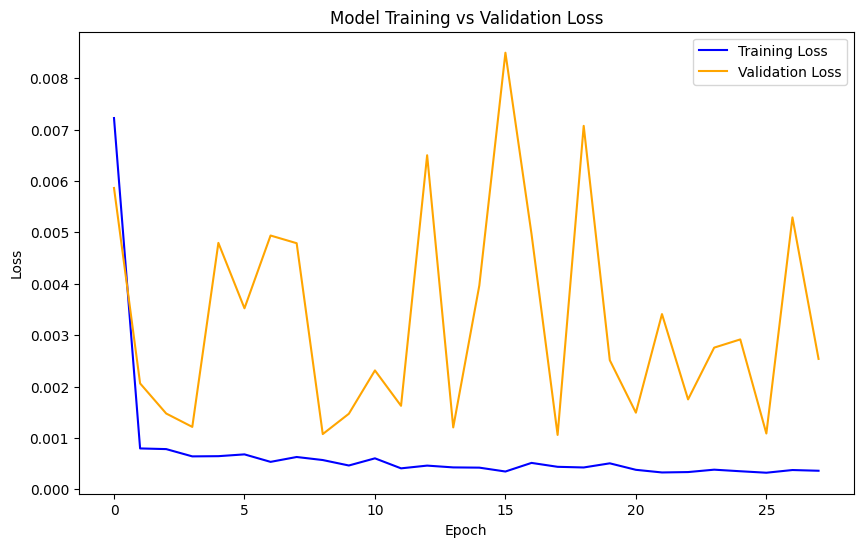

In [58]:

# Plot Training vs Validation Loss

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Model Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
